In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
sales_df = pd.read_csv("../data/phase0_sales.csv")
list_columns = list(sales_df.columns)
list_dates_columns = list_columns[3:]

# Unpivot to get flat format dataframe
sales_df = sales_df.melt(id_vars=['Client', 'Warehouse', 'Product'], var_name='date_key', 
                         value_vars=list_dates_columns, value_name=TARGET_COL)


# Create new delimiter column to form unique identifier
sales_df['item_id'] = sales_df[['Client', 'Warehouse', 'Product']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
sales_df['date_key'] = pd.to_datetime(sales_df['date_key']).dt.date

In [4]:
# CONFIG

# Forecast 13 weeks ahead into the future
FORECAST_PERIOD = 13
TARGET_COL = 'sales_qty'
RANDOM_SEED = 123

In [16]:
def label_demand_type(ts_series):
    '''
    Returns a string indication the time series classification of a series
    There are 5 possible labels, 'Unknown', 'Intermittent', 'Lumpy', 'Smooth', 'Erratic'
        Parameters:
            1. ts_series: A pandas series containing time series to be classified

        Returns:
            ts_label: Time series label
    '''
    if any(ts_series.isna()):
        return "Unknown"
    
    length = ts_series['length']
    summed = ts_series['summed']
    std = ts_series['std']
    mean = ts_series['mean']
    
    if summed == 0 or mean == 0:
        ts_label = "Unknown"
    else:
        adi = length/summed
        cv2 = std/mean
        if adi >= 1.32:
            if cv2 < 0.49:
                ts_label = "Intermittent"
            else:
                ts_label = "Lumpy"
        elif cv2 < 0.49:
            ts_label = "Smooth"
        else:
            ts_label = "Erratic"
    return ts_label

def get_demand_type_flag(df, 
                         target_col, 
                         idx_cols, 
                         output_col) -> pd.DataFrame:
    '''
    Returns a dataframe containing time series classifications based on volatility and intermittency
    There are 5 possible labels, 'Unknown', 'Intermittent', 'Lumpy', 'Smooth', 'Erratic'
        Parameters:
            1. df: A grouped pandas dataframe to apply evaluation on
            2. target_col: Name of target col to do time series classification
            3. idx_cols: List of columns to aggregate against before ts classification
                                     (for eg: ['product_id', 'warehouse_id'])
            4. output_col: Name of output column containing flag generated

        Returns:
            df_result: Dataframe containing time series classification results
    '''
    df_agg = df.groupby(idx_cols).agg(
        length = (target_col, lambda x : len(x)),
        summed = (target_col, lambda x : sum(x > 0)),
        std = (target_col, lambda x : (x[x>0].std(ddof = 0))),
        mean = (target_col, lambda x : x[x>0].mean())
    )
    df_agg[output_col] = df_agg.apply(label_demand_type, axis = 1)
    df_result = df_agg.reset_index()[idx_cols + [output_col]]
    return df_result

demand_type_df = get_demand_type_flag(sales_df, TARGET_COL, ['item_id'], 'demand_type')

In [23]:
sales_df = sales_df.merge(demand_type_df, on='item_id', how='left')

In [26]:
sales_df = sales_df.sort_values(by=['demand_type', 'sales_qty'], ascending=[True, False])

In [27]:
sales_df.query("demand_type == 'Smooth'").query("item_id == '")

,Client,Warehouse,Product,date_key,sales_qty,item_id,demand_type
1112809,41,228,2866,2021-11-29,11422.0,41_228_2866,Smooth
315000,41,228,2866,2020-11-23,10912.0,41_228_2866,Smooth
1955777,41,228,2866,2022-12-26,10475.0,41_228_2866,Smooth
1142915,41,228,2866,2021-12-13,10426.0,41_228_2866,Smooth
330053,41,228,2866,2020-11-30,10259.0,41_228_2866,Smooth
...,...,...,...,...,...,...,...
2544811,0,278,7457,2023-10-02,0.0,0_278_7457,Smooth
2544818,0,278,8587,2023-10-02,0.0,0_278_8587,Smooth
2544820,0,278,8880,2023-10-02,0.0,0_278_8880,Smooth
2544849,0,302,8264,2023-10-02,0.0,0_302_8264,Smooth


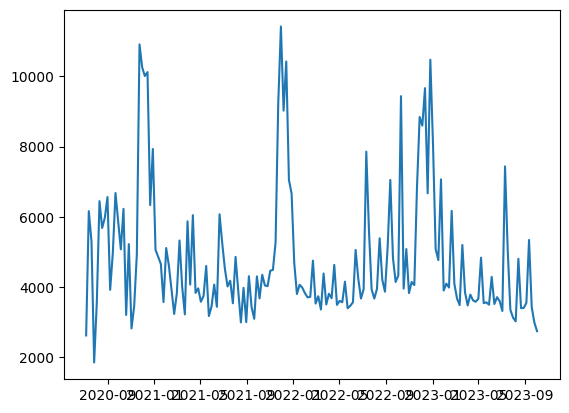

In [29]:
sub_df = sales_df.query("item_id == '41_228_2866'")
sub_df = sub_df.sort_values(by='date_key')

plt.plot(sub_df['date_key'], sub_df['sales_qty'])

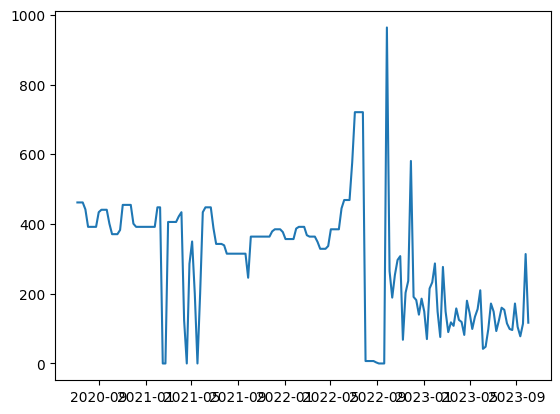

In [21]:
sub_df = sales_df.query("item_id == '0_121_6341'")

plt.plot(sub_df['date_key'], sub_df['sales_qty'])